## Ethereum Notebook
#### Run in *pyvizenv* environment in order to visualize dashboard at the end of the notebook.


### Data Preparation

In [1]:
import numpy as np
import pandas as pd
import hvplot.pandas
from datetime import datetime, date
from functools import reduce
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from bokeh.resources import INLINE

In [2]:
# Load the fear and greed sentiment data for Bitcoin (only fear and greed index)
fng_df = pd.read_csv('data/fng.csv')
fng_df = fng_df.rename(columns={'date':'Date', 'value_classification':'fng_class'})
fng_df = fng_df.drop(columns=['value'])
mapping = {'Extreme Fear':'-1.0', 'Fear':'-0.5', 'Neutral':'0.0', 
        'Greed':'0.5', 'Extreme Greed':'1.0'}
fng_df['fng_class'] = fng_df['fng_class'].map(mapping)
fng_df['fng_class'] = pd.to_numeric(fng_df['fng_class'])
fng_df['fng_class'] = fng_df['fng_class'].astype(float)
fng_df.set_index(['Date'], inplace=True)

In [3]:
# Load the vader sentiment data for Ethereum
eth_vader_df = pd.read_csv('data/eth_vader.csv', infer_datetime_format=True, parse_dates=True)
eth_vader_df["Publish Date"] = [date[0:10] for date in eth_vader_df["Publish Date"]]
eth_vader_df = eth_vader_df.drop(columns=["Post ID", "Title", "Url", "Author", "Score", "Total No. of Comments", "Permalink",
        "title_pos", "title_neu", "title_neg", "title_sent"], axis=1)
eth_vader_df.rename(columns = {'Publish Date':'Date', 'title_compound': 'vader_compound'}, inplace = True)
eth_vader_df['vader_compound'] = eth_vader_df['vader_compound'].astype(float).round(decimals=2)
eth_vader_df.set_index(['Date'], inplace=True)

In [4]:
# Load the historical closing prices for Ethereum
eth_close_df = pd.read_csv('data/eth_prices.csv')
eth_close_df = eth_close_df.sort_index()
eth_close_df = eth_close_df.rename(columns={'date':'Date', 'close':'close_price'})
eth_close_df = eth_close_df.drop(["symbol", "volume"], axis=1)
eth_close_df.set_index(['Date'], inplace=True)

In [5]:
# Load the exponential weighted moving average data for Ethereum
eth_ewm_df = pd.read_csv('data/eth_ema.csv')
eth_ewm_df = eth_ewm_df.sort_index()
eth_ewm_df = eth_ewm_df.rename(columns={'date':'Date', 'crossover_signal':'ewm_cross_signal'})
eth_ewm_df = eth_ewm_df.drop(["symbol", "close", "volume", "daily_return", "fast_close", "slow_close", "crossover_long", "crossover_short"], axis=1)
eth_ewm_df['ewm_cross_signal'] = eth_ewm_df['ewm_cross_signal'].astype(float)
eth_ewm_df.set_index(['Date'], inplace=True)

In [6]:
# Load the money flow index for Ethereum
eth_mfi_df = pd.read_csv('data/eth_mfi.csv')
eth_mfi_df = eth_mfi_df.sort_index()
eth_mfi_df = eth_mfi_df.rename(columns={'date':'Date'})
eth_mfi_df = eth_mfi_df.drop(["symbol", "close", "volume", "Buy", "Sell"], axis=1)
eth_mfi_df['MFI'] = eth_mfi_df['MFI'].round(decimals=2)
eth_mfi_df["mfi_std"] = (eth_mfi_df['MFI'] - eth_mfi_df['MFI'].min())/(eth_mfi_df['MFI'].max() - eth_mfi_df['MFI'].min())
eth_mfi_df = eth_mfi_df.drop(columns=['MFI'])
eth_mfi_df.set_index(['Date'], inplace=True)

In [7]:
# Load the google search data for Ethereum
eth_google_df = pd.read_csv('data/eth_google.csv')
eth_google_df = eth_google_df.sort_index()
eth_google_df = eth_google_df.rename(columns={'Google Search Count':'google_search'})
eth_google_df['google_search'] = eth_google_df['google_search'].astype(float)
eth_google_df["google_std"] = (eth_google_df['google_search'] - eth_google_df['google_search'].min())/(eth_google_df['google_search'].max() - eth_google_df['google_search'].min())
eth_google_df = eth_google_df.drop(columns=['google_search'])
eth_google_df.set_index(['Date'], inplace=True)

In [8]:
# MERGE the closing price, ewm, fng, mfi, and Google DataFrames into a single DataFrame
eth_dfs = [eth_close_df, eth_ewm_df, fng_df, eth_mfi_df, eth_google_df]
eth_data_df = reduce(lambda left, right: pd.merge(left, right, on='Date'), eth_dfs)
eth_df = eth_data_df.merge(eth_vader_df, on = 'Date', how = 'left')
eth_df.rename(columns = {'mfi_std':'mfi', 'google_std':'google_search'}, inplace = True)
eth_df['vader_compound'] = eth_df['vader_compound'].fillna(0)
eth_df = eth_df.reset_index().drop_duplicates(subset="Date", keep="first")
eth_df = eth_df.set_index("Date").sort_index()
round(eth_df,2).head()

close_price  ewm_cross_signal  fng_class   mfi  google_search  \
Date                                                                        
2019-02-11       119.52               1.0       -0.5  0.26           0.04   
2019-02-12       121.18               1.0       -0.5  0.41           0.04   
2019-02-13       120.58               1.0        0.0  0.31           0.04   
2019-02-14       119.37               1.0        0.0  0.35           0.04   
2019-02-15       120.48               1.0       -0.5  0.46           0.04   

            vader_compound  
Date                        
2019-02-11             0.0  
2019-02-12             0.0  
2019-02-13             0.0  
2019-02-14             0.0  
2019-02-15             0.0

In [9]:
# Load the gas price data for Ethereum
eth_gas_df = pd.read_csv('data/eth_gas_price.csv')
eth_gas_df = eth_gas_df.sort_index()
eth_gas_df["f0_"] = [date[0:10] for date in eth_gas_df["f0_"]]
eth_gas_df = eth_gas_df.rename(columns={'f0_':'Date'})
eth_gas_df["gas_std"] = (eth_gas_df['f1_'] - eth_gas_df['f1_'].min())/(eth_gas_df['f1_'].max() - eth_gas_df['f1_'].min())
eth_gas_df.set_index(['Date'], inplace=True)
eth_gas_df = eth_gas_df.drop(columns=['f1_'], axis=1)

In [10]:
# Load the mining difficulty data for Ethereum
eth_diff_df = pd.read_csv('data/eth_difficulty.csv')
eth_diff_df = eth_diff_df.sort_index()
eth_diff_df["f0_"] = [date[0:10] for date in eth_diff_df["f0_"]]
eth_diff_df = eth_diff_df.rename(columns={'f0_':'Date'})
eth_diff_df = eth_diff_df.sort_index()
eth_diff_df['f1_'] = eth_diff_df['f1_'].astype(float)
eth_diff_df["diff_std"] = (eth_diff_df['f1_'] - eth_diff_df['f1_'].min())/(eth_diff_df['f1_'].max() - eth_diff_df['f1_'].min())
eth_diff_df.set_index(['Date'], inplace=True)
eth_diff_df = eth_diff_df.drop(columns=['f1_'], axis=1)

In [11]:
# Load the actual ethereum value (transfers) data for Ethereum (volume of transactions by day)
eth_value_df = pd.read_csv('data/eth_value.csv') #, index_col="date", infer_datetime_format=True, parse_dates=True)
eth_value_df = eth_value_df.sort_index()
eth_value_df["f0_"] = [date[0:10] for date in eth_value_df["f0_"]]
eth_value_df = eth_value_df.rename(columns={'f0_':'Date'})
eth_value_df['f1_'] = eth_value_df['f1_'].astype(float)
eth_value_df["transfers_std"] = (eth_value_df['f1_'] - eth_value_df['f1_'].min())/(eth_value_df['f1_'].max() - eth_value_df['f1_'].min())
eth_value_df.set_index(['Date'], inplace=True)
eth_value_df = eth_value_df.drop(columns=['f1_'], axis=1)

In [12]:
# MERGE the mining data into a single DataFrame
dfs = [eth_diff_df, eth_gas_df, eth_value_df]
eth_mining_df = reduce(lambda left, right: pd.merge(left, right, on='Date'), dfs)
eth_string_time = "2019-02-08"
eth_datetime = datetime.strptime(eth_string_time, "%Y-%m-%d")
eth_mining_df.rename(columns = {'f0_':'Date', 'diff_std':'mining_difficulty', 'gas_std': 'gas_price', 'transfers_std':'total_transfers' }, inplace = True)
round(eth_mining_df,2).head()

mining_difficulty  gas_price  total_transfers
Date                                                     
2019-02-08               0.41       0.00             0.22
2020-12-07               0.85       0.07             0.29
2019-01-11               0.53       0.01             0.41
2020-01-30               0.47       0.00             0.13
2019-05-15               0.46       0.01             0.47

In [13]:
# MERGE eth_mining_df with eth_df
eth_master_df = eth_df.merge(eth_mining_df, on = 'Date', how = 'left')
round(eth_master_df,2).head()

close_price  ewm_cross_signal  fng_class   mfi  google_search  \
Date                                                                        
2019-02-11       119.52               1.0       -0.5  0.26           0.04   
2019-02-12       121.18               1.0       -0.5  0.41           0.04   
2019-02-13       120.58               1.0        0.0  0.31           0.04   
2019-02-14       119.37               1.0        0.0  0.35           0.04   
2019-02-15       120.48               1.0       -0.5  0.46           0.04   

            vader_compound  mining_difficulty  gas_price  total_transfers  
Date                                                                       
2019-02-11             0.0               0.41       0.00             0.19  
2019-02-12             0.0               0.43       0.00             0.15  
2019-02-13             0.0               0.41       0.00             0.18  
2019-02-14             0.0               0.40       0.01             0.17  
2019-02-15             0.0               0.40       0.01             0.16

---

## Random Forest Regressor for Multiple Features

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
#from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.datasets import load_boston
import shap
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


Bad key savefig.frameon in file /Users/cathyslider/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /Users/cathyslider/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /Users/cathyslider/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  #

### Fitting and Predicting

In [15]:
# Define features set and target vector
dataset = eth_master_df
X = eth_master_df[['mining_difficulty', 'ewm_cross_signal','fng_class','mfi','google_search', 'vader_compound', 'gas_price', 'total_transfers']]
y = eth_master_df['close_price']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [17]:
# Create Random Forest Regressor and fit the model
rf_model = RandomForestRegressor(n_estimators=10, random_state=78)
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=78)

In [18]:
# Make predictions using the testing data
predictions = rf_model.predict(X_test)

### Feature Importance

In [19]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.8980640143718908, 'mining_difficulty'),
 (0.048044449303026864, 'google_search'),
 (0.01756077660387655, 'mfi'),
 (0.015225957134671354, 'gas_price'),
 (0.010189599370537379, 'fng_class'),
 (0.0096042045644838, 'total_transfers'),
 (0.0009479322644170564, 'ewm_cross_signal'),
 (0.0003630663870963442, 'vader_compound')]

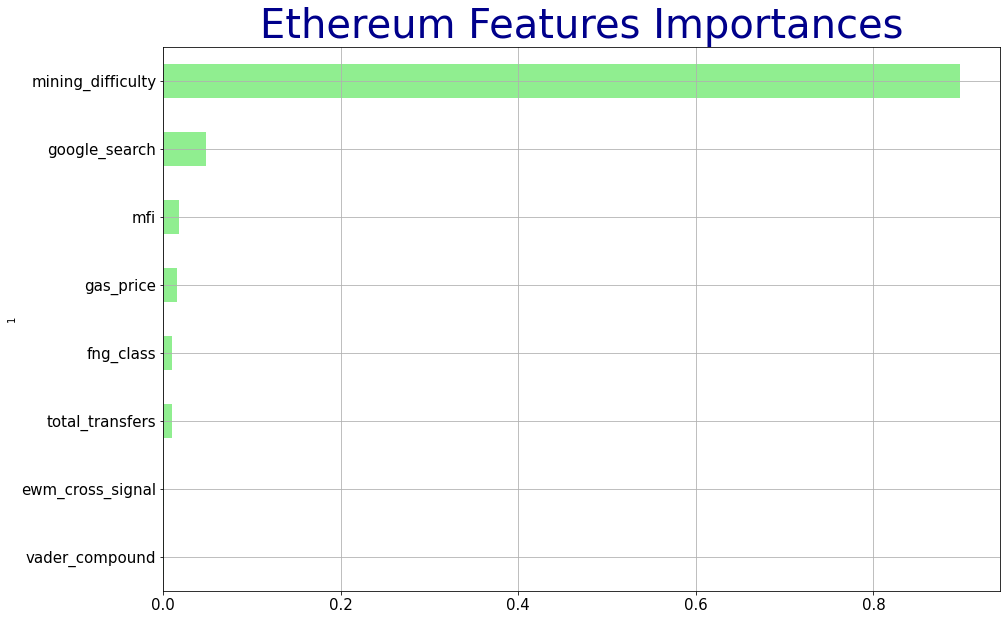

In [20]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', figsize=(15,10), grid=True, 
                        fontsize=15, legend=False)
plt.title('Ethereum Features Importances', fontsize=40, color='darkBlue')
plt.savefig('images/eth-features-import.png')

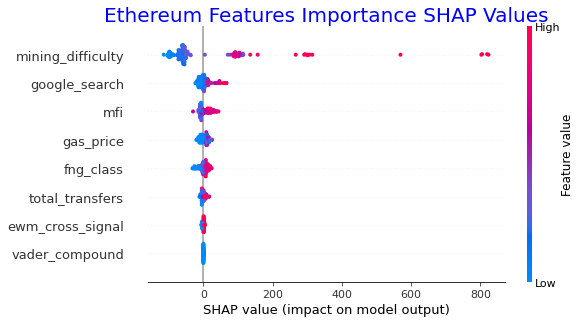

In [21]:
# Plot SHAP Values
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)
plt.title('Ethereum Features Importance SHAP Values', fontsize=20, color='blue', pad=(5.0))
plt.savefig('images/eth-features-import-shap.png')
shap.summary_plot(shap_values, X_test)

### Model Evaluation

In [22]:
# r2_score (fit score) test
from sklearn.metrics import r2_score,mean_squared_error
round(r2_score(y_test, rf_model.predict(X_test)),3)

0.979

In [23]:
# FIX PERCENTAGE mean squared error
mse = mean_squared_error(y_test, rf_model.predict(X_test), squared=False)
round(mse,3)

29.608

In [24]:
rmse = np.sqrt(mse)
round(rmse,3)

5.441

In [25]:
eth_master_train_df, eth_master_test_df= np.split(eth_master_df, [int(.8 *len(eth_master_df))])
pred_df = pd.DataFrame(predictions, columns=['prediction_price'])
#pred_df = pred_df.append(eth_close_df)
pred_df.index = eth_master_test_df.index
round(pred_df,2).head()

prediction_price
Date                        
2020-08-28            204.05
2020-08-29            232.72
2020-08-30            236.49
2020-08-31            152.97
2020-09-01            390.93

In [26]:
#Join dataframes
eth_combined = eth_master_df.join(pred_df)
round(eth_combined,2).head()

close_price  ewm_cross_signal  fng_class   mfi  google_search  \
Date                                                                        
2019-02-11       119.52               1.0       -0.5  0.26           0.04   
2019-02-12       121.18               1.0       -0.5  0.41           0.04   
2019-02-13       120.58               1.0        0.0  0.31           0.04   
2019-02-14       119.37               1.0        0.0  0.35           0.04   
2019-02-15       120.48               1.0       -0.5  0.46           0.04   

            vader_compound  mining_difficulty  gas_price  total_transfers  \
Date                                                                        
2019-02-11             0.0               0.41       0.00             0.19   
2019-02-12             0.0               0.43       0.00             0.15   
2019-02-13             0.0               0.41       0.00             0.18   
2019-02-14             0.0               0.40       0.01             0.17   
2019-02-15             0.0               0.40       0.01             0.16   

            prediction_price  
Date                          
2019-02-11               NaN  
2019-02-12               NaN  
2019-02-13               NaN  
2019-02-14               NaN  
2019-02-15               NaN

In [27]:
#Calculate percent change
eth_master_pct_change = eth_combined.pct_change()
eth_master_pct_change_corr = eth_master_pct_change.corr()
round(eth_master_pct_change_corr,2)

close_price  ewm_cross_signal  fng_class   mfi  \
close_price               1.00             -0.00      -0.03  0.15   
ewm_cross_signal         -0.00              1.00       0.01  0.01   
fng_class                -0.03              0.01       1.00  0.02   
mfi                       0.15              0.01       0.02  1.00   
google_search             0.01              0.02       0.01 -0.01   
vader_compound            0.10             -0.00       0.10  0.25   
mining_difficulty        -0.02              0.04       0.01  0.02   
gas_price                -0.07              0.00      -0.01 -0.03   
total_transfers          -0.03             -0.11      -0.03 -0.04   
prediction_price          0.09             -0.05       0.01 -0.02   

                   google_search  vader_compound  mining_difficulty  \
close_price                 0.01            0.10              -0.02   
ewm_cross_signal            0.02           -0.00               0.04   
fng_class                   0.01            0.10               0.01   
mfi                        -0.01            0.25               0.02   
google_search               1.00           -0.00              -0.03   
vader_compound             -0.00            1.00              -0.11   
mining_difficulty          -0.03           -0.11               1.00   
gas_price                  -0.06           -0.37               0.05   
total_transfers             0.04           -0.45              -0.05   
prediction_price            0.00           -0.08               0.10   

                   gas_price  total_transfers  prediction_price  
close_price            -0.07            -0.03              0.09  
ewm_cross_signal        0.00            -0.11             -0.05  
fng_class              -0.01            -0.03              0.01  
mfi                    -0.03            -0.04             -0.02  
google_search          -0.06             0.04              0.00  
vader_compound         -0.37            -0.45             -0.08  
mining_difficulty       0.05            -0.05              0.10  
gas_price               1.00             0.18             -0.02  
total_transfers         0.18             1.00              0.01  
prediction_price       -0.02             0.01              1.00

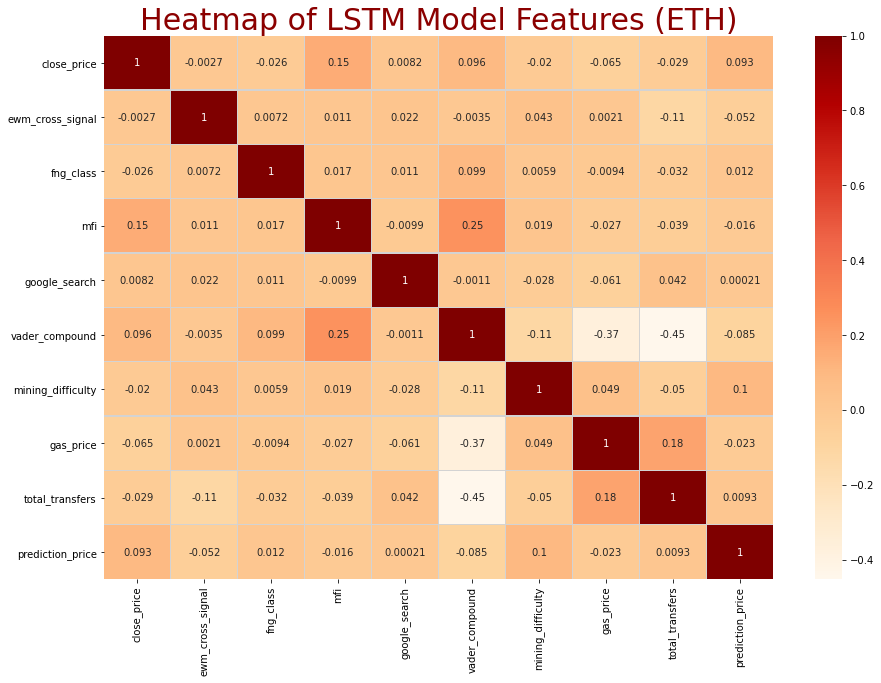

In [28]:
# Plot features importances heatmap
plt.figure(figsize = (15,10))
sns.heatmap(eth_master_pct_change_corr,cmap='OrRd', annot=True, linecolor='lightgray', linewidths=.3)
plt.title('Heatmap of LSTM Model Features (ETH)', color='darkred', pad=3.0, fontsize = 30)
plt.savefig("images/eth-rf-heatmap.png")

---

### RF Analysis for Win/Lose Call Accuracy

In [29]:
#Add column for "actual_day_positive_move" positive move = true & negative move = false
eth_combined["actual_day_positive_move"] = eth_combined["close_price"]-eth_combined["close_price"].shift(1)>0
round(eth_combined,2).tail()

close_price  ewm_cross_signal  fng_class   mfi  google_search  \
Date                                                                        
2021-01-12      1049.98               1.0        1.0  0.52           0.69   
2021-01-13      1129.90               1.0        1.0  0.54           0.69   
2021-01-14      1231.08               1.0        1.0  0.59           0.69   
2021-01-15      1168.24               1.0        1.0  0.55           0.69   
2021-01-16      1260.48               1.0        1.0  0.58           0.69   

            vader_compound  mining_difficulty  gas_price  total_transfers  \
Date                                                                        
2021-01-12             0.0               0.98       0.13             0.39   
2021-01-13             0.0               0.98       0.10             0.41   
2021-01-14             0.0               0.98       0.13             0.71   
2021-01-15             0.0               0.98       0.15             0.40   
2021-01-16             0.0               1.00       0.12             0.30   

            prediction_price  actual_day_positive_move  
Date                                                    
2021-01-12            177.49                     False  
2021-01-13            133.20                      True  
2021-01-14            362.84                      True  
2021-01-15            243.48                     False  
2021-01-16            335.79                      True

In [30]:
#Add column for "predicted_day_positive_move" positive move = true & negative move = false
eth_combined["predicted_day_positive_move"] = eth_combined["prediction_price"]-eth_combined["prediction_price"].shift(1)>0
round(eth_combined,2).tail()

close_price  ewm_cross_signal  fng_class   mfi  google_search  \
Date                                                                        
2021-01-12      1049.98               1.0        1.0  0.52           0.69   
2021-01-13      1129.90               1.0        1.0  0.54           0.69   
2021-01-14      1231.08               1.0        1.0  0.59           0.69   
2021-01-15      1168.24               1.0        1.0  0.55           0.69   
2021-01-16      1260.48               1.0        1.0  0.58           0.69   

            vader_compound  mining_difficulty  gas_price  total_transfers  \
Date                                                                        
2021-01-12             0.0               0.98       0.13             0.39   
2021-01-13             0.0               0.98       0.10             0.41   
2021-01-14             0.0               0.98       0.13             0.71   
2021-01-15             0.0               0.98       0.15             0.40   
2021-01-16             0.0               1.00       0.12             0.30   

            prediction_price  actual_day_positive_move  \
Date                                                     
2021-01-12            177.49                     False   
2021-01-13            133.20                      True   
2021-01-14            362.84                      True   
2021-01-15            243.48                     False   
2021-01-16            335.79                      True   

            predicted_day_positive_move  
Date                                     
2021-01-12                        False  
2021-01-13                        False  
2021-01-14                         True  
2021-01-15                        False  
2021-01-16                         True

In [31]:
# Add "correct call" column if both had true or both had false we have a true 
eth_combined_call = eth_combined
eth_combined_call["Correct Call Count"] = np.where(eth_combined["actual_day_positive_move"]==eth_combined["predicted_day_positive_move"], True, False)
eth_combined_call.to_csv(r"data/eth_combined_call.csv", index = False)
eth_combined_call.tail()

close_price  ewm_cross_signal  fng_class       mfi  google_search  \
Date                                                                            
2021-01-12      1049.98               1.0        1.0  0.519285       0.690722   
2021-01-13      1129.90               1.0        1.0  0.539827       0.690722   
2021-01-14      1231.08               1.0        1.0  0.591392       0.690722   
2021-01-15      1168.24               1.0        1.0  0.552963       0.690722   
2021-01-16      1260.48               1.0        1.0  0.583706       0.690722   

            vader_compound  mining_difficulty  gas_price  total_transfers  \
Date                                                                        
2021-01-12             0.0           0.976442   0.130492         0.389656   
2021-01-13             0.0           0.979995   0.097449         0.412667   
2021-01-14             0.0           0.982190   0.130189         0.714004   
2021-01-15             0.0           0.983228   0.149419         0.396231   
2021-01-16             0.0           1.000000   0.124411         0.300899   

            prediction_price  actual_day_positive_move  \
Date                                                     
2021-01-12           177.491                     False   
2021-01-13           133.201                      True   
2021-01-14           362.839                      True   
2021-01-15           243.476                     False   
2021-01-16           335.795                      True   

            predicted_day_positive_move  Correct Call Count  
Date                                                         
2021-01-12                        False                True  
2021-01-13                        False               False  
2021-01-14                         True                True  
2021-01-15                        False                True  
2021-01-16                         True                True

### Backtesting Random Forest Regressor

In [32]:
#Create signal call (actual buy or sell)
eth_combined["predicted_day_positive_move_shifted"] = eth_combined["predicted_day_positive_move"].shift(-1)
eth_combined['signal_buy'] = np.where((eth_combined["predicted_day_positive_move"]==False ) & (eth_combined['predicted_day_positive_move_shifted']==True), 1.0, 0.0)
eth_combined['signal_sell'] = np.where((eth_combined["predicted_day_positive_move"]==True ) & (eth_combined['predicted_day_positive_move_shifted']==False), -1.0, 0.0)
eth_combined['signal'] = eth_combined['signal_buy'] + eth_combined['signal_sell']
eth_combined.drop(columns=['signal_buy', 'signal_sell'], inplace=True)
# Automated last cell to close portfolio
eth_combined.iloc[-1, eth_combined.columns.get_loc('signal')] = -1.0
eth_combined.tail()

close_price  ewm_cross_signal  fng_class       mfi  google_search  \
Date                                                                            
2021-01-12      1049.98               1.0        1.0  0.519285       0.690722   
2021-01-13      1129.90               1.0        1.0  0.539827       0.690722   
2021-01-14      1231.08               1.0        1.0  0.591392       0.690722   
2021-01-15      1168.24               1.0        1.0  0.552963       0.690722   
2021-01-16      1260.48               1.0        1.0  0.583706       0.690722   

            vader_compound  mining_difficulty  gas_price  total_transfers  \
Date                                                                        
2021-01-12             0.0           0.976442   0.130492         0.389656   
2021-01-13             0.0           0.979995   0.097449         0.412667   
2021-01-14             0.0           0.982190   0.130189         0.714004   
2021-01-15             0.0           0.983228   0.149419         0.396231   
2021-01-16             0.0           1.000000   0.124411         0.300899   

            prediction_price  actual_day_positive_move  \
Date                                                     
2021-01-12           177.491                     False   
2021-01-13           133.201                      True   
2021-01-14           362.839                      True   
2021-01-15           243.476                     False   
2021-01-16           335.795                      True   

            predicted_day_positive_move  Correct Call Count  \
Date                                                          
2021-01-12                        False                True   
2021-01-13                        False               False   
2021-01-14                         True                True   
2021-01-15                        False                True   
2021-01-16                         True                True   

           predicted_day_positive_move_shifted  signal  
Date                                                    
2021-01-12                               False     0.0  
2021-01-13                                True     1.0  
2021-01-14                               False    -1.0  
2021-01-15                                True     1.0  
2021-01-16                                 NaN    -1.0

In [33]:
#Deetermine returns based on predicted calls
eth_combined['cash_flow'] = eth_combined['close_price']*eth_combined['signal']
eth_combined["cash_flow"].iloc[0] = eth_combined['close_price'].iloc[0]
eth_combined['cash_flow'].iloc[-1] = -eth_combined['close_price'].iloc[-1]
round(eth_combined['cash_flow'].sum(),2) * -1


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


609.28

In [34]:
#Determine hodl profit
initial_capital = eth_combined['close_price'].iloc[0]
prediction_profits = eth_combined['cash_flow'].sum() * -1
hodl_profits = eth_combined['close_price'].iloc[-1] - initial_capital
hodl_profits

1140.96

In [35]:
#Merge both prediction profits and hodl profits into a dataframe
rf_df_data = {'prediction_profits': [prediction_profits], 'hodl_profits': [hodl_profits]}
rf_df = pd.DataFrame(data=rf_df_data, dtype=np.int64, index=['usd'])
rf_df = rf_df.applymap("${0:.2f}".format)
rf_df

prediction_profits hodl_profits
usd            $609.28     $1140.96

In [36]:
# Set initial capital
initial_capital = 350
# Set the share size
share_size = 1
# Take a 500 share position where the dual moving average crossover is 1 (SMA50 is greater than SMA100)
eth_combined['Position'] = share_size * eth_combined['signal']
# Find the points in time where a 500 share position is bought or sold
eth_combined['Entry/Exit Position'] = eth_combined['Position'].diff()
# Multiply share price by entry/exit positions and get the cumulatively sum
eth_combined['Portfolio Holdings'] = eth_combined['close_price'] * eth_combined['Entry/Exit Position'].cumsum()
# Subtract the initial capital by the portfolio holdings to get the amount of liquid cash in the portfolio
eth_combined['Portfolio Cash'] = initial_capital - (eth_combined['close_price'] * eth_combined['Entry/Exit Position']).cumsum()
# Get the total portfolio value by adding the cash amount by the portfolio holdings (or investments)
eth_combined['Portfolio Total'] = eth_combined['Portfolio Cash'] + eth_combined['Portfolio Holdings']
# Calculate the portfolio daily returns
eth_combined['Portfolio Daily Returns'] = eth_combined['Portfolio Total'].pct_change()
# Calculate the cumulative returns
eth_combined['Portfolio Cumulative Returns'] = (1 + eth_combined['Portfolio Daily Returns']).cumprod() - 1
# Print the DataFrame
eth_combined.tail(5)

close_price  ewm_cross_signal  fng_class       mfi  google_search  \
Date                                                                            
2021-01-12      1049.98               1.0        1.0  0.519285       0.690722   
2021-01-13      1129.90               1.0        1.0  0.539827       0.690722   
2021-01-14      1231.08               1.0        1.0  0.591392       0.690722   
2021-01-15      1168.24               1.0        1.0  0.552963       0.690722   
2021-01-16      1260.48               1.0        1.0  0.583706       0.690722   

            vader_compound  mining_difficulty  gas_price  total_transfers  \
Date                                                                        
2021-01-12             0.0           0.976442   0.130492         0.389656   
2021-01-13             0.0           0.979995   0.097449         0.412667   
2021-01-14             0.0           0.982190   0.130189         0.714004   
2021-01-15             0.0           0.983228   0.149419         0.396231   
2021-01-16             0.0           1.000000   0.124411         0.300899   

            prediction_price  ...  predicted_day_positive_move_shifted  \
Date                          ...                                        
2021-01-12           177.491  ...                                False   
2021-01-13           133.201  ...                                 True   
2021-01-14           362.839  ...                                False   
2021-01-15           243.476  ...                                 True   
2021-01-16           335.795  ...                                  NaN   

            signal  cash_flow Position  Entry/Exit Position  \
Date                                                          
2021-01-12     0.0       0.00      0.0                  1.0   
2021-01-13     1.0    1129.90      1.0                  1.0   
2021-01-14    -1.0   -1231.08     -1.0                 -2.0   
2021-01-15     1.0    1168.24      1.0                  2.0   
2021-01-16    -1.0   -1260.48     -1.0                 -2.0   

            Portfolio Holdings  Portfolio Cash  Portfolio Total  \
Date                                                              
2021-01-12                0.00          718.33           718.33   
2021-01-13             1129.90         -411.57           718.33   
2021-01-14            -1231.08         2050.59           819.51   
2021-01-15             1168.24         -285.89           882.35   
2021-01-16            -1260.48         2235.07           974.59   

            Portfolio Daily Returns  Portfolio Cumulative Returns  
Date                                                               
2021-01-12                 0.057347                      1.052371  
2021-01-13                 0.000000                      1.052371  
2021-01-14                 0.140854                      1.341457  
2021-01-15                 0.076680                      1.521000  
2021-01-16                 0.104539                      1.784543  

[5 rows x 23 columns]

In [37]:
#Visualize prediction profits (precise buys and sells) with 'total porfolio value'

# Visualize exit position relative to total portfolio value
def rf_prediction_profits():

    exit = eth_combined[eth_combined['signal'] == -1.0]['close_price'].hvplot.scatter(
        color='red',
        legend=True,
        ylabel='Total Portfolio Value (same as share price)',
        width=800,
        height=400
    )

    # Visualize entry position relative to total portfolio value
    entry = eth_combined[eth_combined['signal'] == 1.0]['close_price'].hvplot.scatter(
        color='green',
        legend=True,
        ylabel='Total Portfolio Value (same as share price)',
        width=800,
        height=400
    )

    # Visualize total portfolio value for the investment
    total_portfolio_value = eth_combined[['close_price']].hvplot.line(
        line_color='lightgray',
        ylabel='Total Portfolio Value (same as share price)',
        width=800,
        height=400
    )

    # Overlay plots
    portfolio_entry_exit_plot = total_portfolio_value * entry * exit
    portfolio_entry_exit_plot.opts(
        xaxis=False, 
        title = ('Random Forest Regressor Predictive Buy/Sell Calls'))
    hvplot.save(portfolio_entry_exit_plot,'images/eth-rf-buy-sell.png', resources=INLINE)
    portfolio_entry_exit_plot
    
    return portfolio_entry_exit_plot

rf_prediction_profits()

:Overlay
   .Curve.I                :Curve   [Date]   (close_price)
   .Scatter.Close_price.I  :Scatter   [Date]   (close_price)
   .Scatter.Close_price.II :Scatter   [Date]   (close_price)

In [38]:
# Prepare DataFrame for metrics
metrics = [
    'Annual Return',
    'Cumulative Returns',
    'Annual Volatility',
    'Sharpe Ratio',
    'Sortino Ratio']
columns = ['Backtest']
# Initialize the DataFrame with index set to evaluation metrics and column as `Backtest` (just like PyFolio)
rf_portfolio_evaluation_df = pd.DataFrame(index=metrics, columns=columns)

In [39]:
#BACKTESTING based on predicted price
# Calculate cumulative return
rf_portfolio_evaluation_df.loc['Cumulative Returns'] = eth_combined['Portfolio Cumulative Returns'][-1]
# Calculate annualized return
rf_portfolio_evaluation_df.loc['Annual Return'] = (
    eth_combined['Portfolio Daily Returns'].mean() * 252
)
# Calculate annual volatility
rf_portfolio_evaluation_df.loc['Annual Volatility'] = (
    eth_combined['Portfolio Daily Returns'].std() * np.sqrt(252)
)
# Calculate Sharpe Ratio
rf_portfolio_evaluation_df.loc['Sharpe Ratio'] = (
    eth_combined['Portfolio Daily Returns'].mean() * 252) / (
    eth_combined['Portfolio Daily Returns'].std() * np.sqrt(252)
)
# Calculate Downside Return
sortino_ratio_df = eth_combined[['Portfolio Daily Returns']].copy()
sortino_ratio_df.loc[:,'Downside Returns'] = 0
target = 0
mask = sortino_ratio_df['Portfolio Daily Returns'] < target
sortino_ratio_df.loc[mask, 'Downside Returns'] = sortino_ratio_df['Portfolio Daily Returns']**2
rf_portfolio_evaluation_df
# Calculate Sortino Ratio
down_stdev = np.sqrt(sortino_ratio_df['Downside Returns'].mean()) * np.sqrt(252)
expected_return = sortino_ratio_df['Portfolio Daily Returns'].mean() * 252
sortino_ratio = expected_return/down_stdev
rf_portfolio_evaluation_df.loc['Sortino Ratio'] = sortino_ratio
rf_portfolio_evaluation_df.head()

Backtest
Annual Return        0.43329
Cumulative Returns   1.78454
Annual Volatility   0.383438
Sharpe Ratio         1.13001
Sortino Ratio        2.63062

### Create pivot table for call accuracy

In [40]:
#Remove rows w/o predicted prices
rf_eth_calls = eth_combined_call.iloc[565:]

In [41]:
# convert to pivot table
rf_eth_calls = rf_eth_calls.pivot_table(index=['Correct Call Count'], aggfunc='size')
rf_eth_calls

Correct Call Count
False    64
True     77
dtype: int64

In [42]:
# calculate lose rate
rf_eth_calls['lose_rate'] = (rf_eth_calls.iloc[0] / (141))*100
round(rf_eth_calls,2)

Correct Call Count
False        64.00
True         77.00
lose_rate    45.39
dtype: float64

In [43]:
# calculate win rate
rf_eth_calls['win_rate'] = (rf_eth_calls.iloc[1] / (141))*100
round(rf_eth_calls,2)

Correct Call Count
False        64.00
True         77.00
lose_rate    45.39
win_rate     54.61
dtype: float64

---

## Features Decision Tree

In [44]:
from sklearn import datasets
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_iris
from sklearn import tree
import pydotplus
from IPython.display import Image

In [45]:
# Prepare the data
dataset = eth_combined
X = eth_combined[['close_price','ewm_cross_signal','fng_class','mfi','google_search', 'vader_compound', 'mining_difficulty', 'gas_price', 'total_transfers']]
y = eth_combined["close_price"]

In [46]:
# Fit the regressor, set max_depth = 3
regr = DecisionTreeRegressor(max_depth=3, min_samples_leaf=25, random_state=78)
model = regr.fit(X, y)

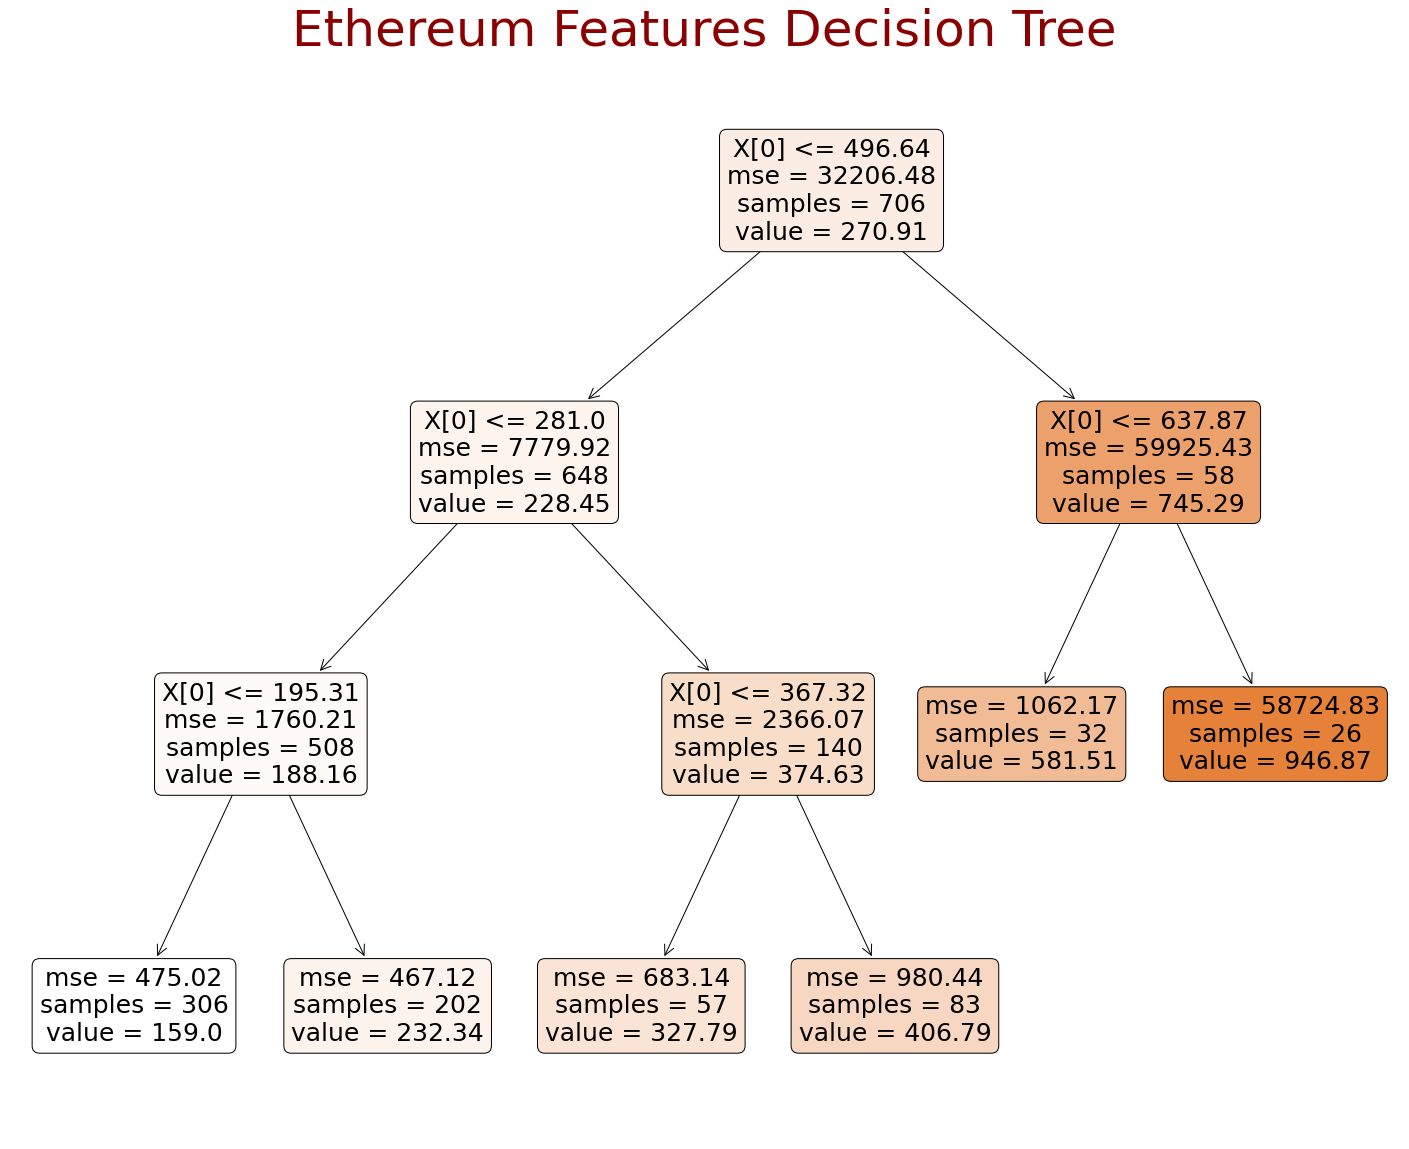

In [47]:
fig = plt.figure(figsize=(25,20))

fig = tree.plot_tree(regr, filled=True, rounded=True, precision=2, fontsize=25)
plt.title('Ethereum Features Decision Tree', fontsize=50, color='darkred')
plt.savefig('images/eth-decision-tree.png')

In [48]:
eth_features = eth_master_df.join(pred_df)
round(eth_features,2).head()

close_price  ewm_cross_signal  fng_class   mfi  google_search  \
Date                                                                        
2019-02-11       119.52               1.0       -0.5  0.26           0.04   
2019-02-12       121.18               1.0       -0.5  0.41           0.04   
2019-02-13       120.58               1.0        0.0  0.31           0.04   
2019-02-14       119.37               1.0        0.0  0.35           0.04   
2019-02-15       120.48               1.0       -0.5  0.46           0.04   

            vader_compound  mining_difficulty  gas_price  total_transfers  \
Date                                                                        
2019-02-11             0.0               0.41       0.00             0.19   
2019-02-12             0.0               0.43       0.00             0.15   
2019-02-13             0.0               0.41       0.00             0.18   
2019-02-14             0.0               0.40       0.01             0.17   
2019-02-15             0.0               0.40       0.01             0.16   

            prediction_price  
Date                          
2019-02-11               NaN  
2019-02-12               NaN  
2019-02-13               NaN  
2019-02-14               NaN  
2019-02-15               NaN

----

## LSTM Recurrent Neural Network for Historical and Predicted Closing Prices

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from numpy.random import seed
from tensorflow import random
from sklearn.preprocessing import MinMaxScaler

In [50]:
# Set the random seed for reproducibility
seed(1)
random.set_seed(2)

In [51]:
# Create function for features (X) and targeet(y)
def window_data(eth_combined, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(eth_combined) - window - 1):
        features = eth_combined.iloc[i:(i + window), feature_col_number]
        target = eth_combined.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [52]:
# Predict Closing Prices 
window_size = 10

# Column 0 is `Close Price`
feature_column = 0
target_column = 0
X, y = window_data(eth_combined, window_size, feature_column, target_column)

In [53]:
# Use 70% of the data for training and the remainder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test_scaler = y[split:]

In [54]:
# Use the MinMaxScaler to scale data between 0 and 1.
scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test_scaler = scaler.transform(y_test_scaler)


In [55]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

---

### Build and Train the Model

In [56]:
# Define the LSTM RNN model.
model = Sequential()

# Initial model setup
number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,             #carries the values forward
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))


In [57]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [58]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 30)            3840      
_________________________________________________________________
dropout (Dropout)            (None, 10, 30)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 30)            7320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 30)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3

In [59]:
# Train the model
model.fit(X_train, y_train, epochs=50, shuffle=False, batch_size=100, verbose=0)

---

### Model Performance

In [60]:
# Evaluate the model
model.evaluate(X_test, y_test_scaler)

7/7 [==============================] - 1s 3ms/step - loss: 0.0071


0.007103798445314169

In [61]:
# Make some predictions
predicted = model.predict(X_test)

In [62]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
#np.round(predicted_prices, 2)
real_prices = scaler.inverse_transform(y_test_scaler.reshape(-1, 1))

In [63]:
# Create a DataFrame of Real and Predicted values
lstm_df = pd.DataFrame({
    'Historical': real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = eth_combined.index[-len(real_prices): ]) 
#np.around(lstm_df, 2)
round(lstm_df,2).head()

Historical   Predicted
Date                              
2020-06-22      227.85  227.869995
2020-06-23      243.22  227.770004
2020-06-24      243.03  227.190002
2020-06-25      234.54  226.899994
2020-06-26      232.32  227.389999

In [64]:
# Set the short window and long windows
short_window = 50
long_window = 100

# Generate the short and long moving averages (50 and 100 days, respectively)
lstm_df['SMA50'] = lstm_df['Historical'].rolling(window=short_window).mean()
lstm_df['SMA100'] = lstm_df['Historical'].rolling(window=long_window).mean()
lstm_df['Signal'] = 0.0
# Generate the trading signal 0 or 1,
# where 0 is when the SMA50 is under the SMA100, and
# where 1 is when the SMA50 is higher (or crosses over) the SMA100
lstm_df['Signal'][short_window:] = np.where(
    lstm_df['SMA50'][short_window:] > lstm_df['SMA100'][short_window:], 1.0, 0.0
)
# Calculate the points in time at which a position should be taken, 1 or -1
lstm_df['Entry/Exit'] = lstm_df['Signal'].diff()
# Print the DataFrame
round(lstm_df,2).head()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Historical   Predicted  SMA50  SMA100  Signal  Entry/Exit
Date                                                                 
2020-06-22      227.85  227.869995    NaN     NaN     0.0         NaN
2020-06-23      243.22  227.770004    NaN     NaN     0.0         0.0
2020-06-24      243.03  227.190002    NaN     NaN     0.0         0.0
2020-06-25      234.54  226.899994    NaN     NaN     0.0         0.0
2020-06-26      232.32  227.389999    NaN     NaN     0.0         0.0

FixedFormatter should only be used together with FixedLocator


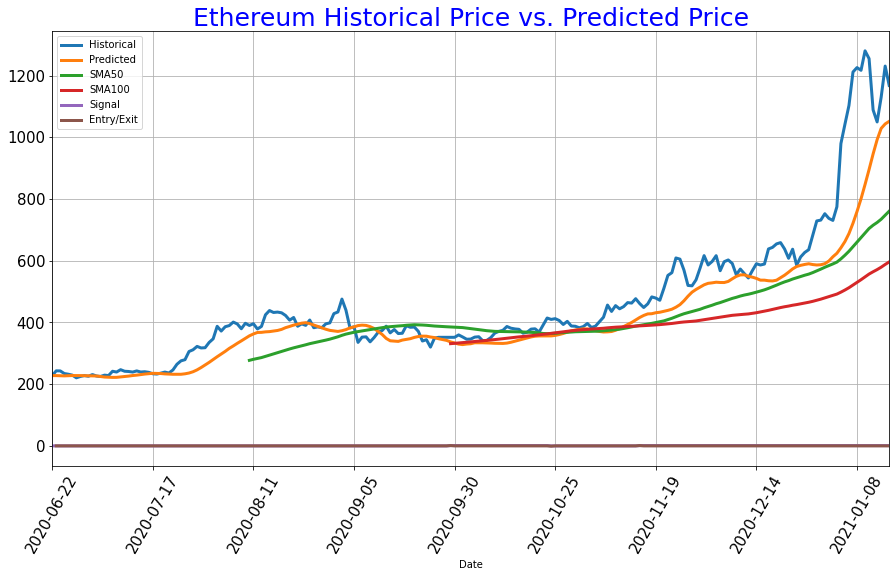

In [65]:
# Plot price comparison
lstm_df.plot(figsize=(15,8), fontsize=15, grid=True, linewidth=3, rot=60)
plt.title('Ethereum Historical Price vs. Predicted Price', fontsize=25, 
          fontweight=15, color='blue', pad=1.0)
plt.savefig('images/eth-lstm.png')

In [66]:
#Add column for "actual_day_positive_move" positive move = true & negative move = false
lstm_df["actual_day_positive_move"] = lstm_df['Historical']-lstm_df['Historical'].shift(1)>0
round(lstm_df,2).tail()

Historical    Predicted   SMA50  SMA100  Signal  Entry/Exit  \
Date                                                                      
2021-01-12     1088.94   946.169983  715.26  564.41     1.0         0.0   
2021-01-13     1049.98   992.440002  724.08  571.39     1.0         0.0   
2021-01-14     1129.90  1029.010010  734.57  579.15     1.0         0.0   
2021-01-15     1231.08  1043.510010  747.80  588.05     1.0         0.0   
2021-01-16     1168.24  1051.959961  760.77  596.32     1.0         0.0   

            actual_day_positive_move  
Date                                  
2021-01-12                     False  
2021-01-13                     False  
2021-01-14                      True  
2021-01-15                      True  
2021-01-16                     False

In [67]:
#Add column for "predicted day positive move" positive move = true & negative move = false
lstm_df["predicted_day_positive_move"] = lstm_df["Predicted"]-lstm_df["Predicted"].shift(1)>0
round(lstm_df,2).tail()

Historical    Predicted   SMA50  SMA100  Signal  Entry/Exit  \
Date                                                                      
2021-01-12     1088.94   946.169983  715.26  564.41     1.0         0.0   
2021-01-13     1049.98   992.440002  724.08  571.39     1.0         0.0   
2021-01-14     1129.90  1029.010010  734.57  579.15     1.0         0.0   
2021-01-15     1231.08  1043.510010  747.80  588.05     1.0         0.0   
2021-01-16     1168.24  1051.959961  760.77  596.32     1.0         0.0   

            actual_day_positive_move  predicted_day_positive_move  
Date                                                               
2021-01-12                     False                         True  
2021-01-13                     False                         True  
2021-01-14                      True                         True  
2021-01-15                      True                         True  
2021-01-16                     False                         True

In [68]:
#create signal call (actual buy or sell)
lstm_df["predicted_day_positive_move_shifted"] = lstm_df["predicted_day_positive_move"].shift(-1)
lstm_df['signal_buy'] = np.where((lstm_df["predicted_day_positive_move"]==False ) & (lstm_df['predicted_day_positive_move_shifted']==True), 1.0, 0.0)
lstm_df['signal_sell'] = np.where((lstm_df["predicted_day_positive_move"]==True ) & (lstm_df['predicted_day_positive_move_shifted']==False), -1.0, 0.0)
lstm_df['signal'] = lstm_df['signal_buy'] + lstm_df['signal_sell']
lstm_df.drop(columns=['signal_buy', 'signal_sell'], inplace=True)
# Automate last cell to close portfolio
lstm_df.iloc[-1, lstm_df.columns.get_loc('signal')] = -1.0
lstm_df.tail()

Historical    Predicted     SMA50    SMA100  Signal  Entry/Exit  \
Date                                                                          
2021-01-12     1088.94   946.168457  715.2592  564.4130     1.0         0.0   
2021-01-13     1049.98   992.444214  724.0770  571.3874     1.0         0.0   
2021-01-14     1129.90  1029.009033  734.5694  579.1487     1.0         0.0   
2021-01-15     1231.08  1043.506104  747.8006  588.0516     1.0         0.0   
2021-01-16     1168.24  1051.957275  760.7654  596.3160     1.0         0.0   

            actual_day_positive_move  predicted_day_positive_move  \
Date                                                                
2021-01-12                     False                         True   
2021-01-13                     False                         True   
2021-01-14                      True                         True   
2021-01-15                      True                         True   
2021-01-16                     False                         True   

           predicted_day_positive_move_shifted  signal  
Date                                                    
2021-01-12                                True     0.0  
2021-01-13                                True     0.0  
2021-01-14                                True     0.0  
2021-01-15                                True     0.0  
2021-01-16                                 NaN    -1.0

In [69]:
#Determine returns based on predicted calls
lstm_df['cash_flow'] = lstm_df['Historical']*lstm_df['signal']
lstm_df["cash_flow"].iloc[0] = lstm_df['Historical'].iloc[0]
lstm_df['cash_flow'].iloc[-1] = -lstm_df['Historical'].iloc[-1]
round(lstm_df['cash_flow'].sum(),2) * -1


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


380.54

In [70]:
#Determine hodl profit
initial_capital = lstm_df['Historical'].iloc[0]
prediction_profits = lstm_df['cash_flow'].sum() * -1
hodl_profits = lstm_df['Historical'].iloc[-1] - initial_capital
hodl_profits

940.39

In [71]:
#Merge both prediction profits and hodl profits into a dataframe
df_data = {'prediction_profits': [prediction_profits], 'hodl_profits': [hodl_profits]}
df = pd.DataFrame(data=df_data, dtype=np.int64, index=['usd'])
df = df.applymap("${0:.2f}".format)
df

prediction_profits hodl_profits
usd            $380.54      $940.39

In [72]:
# Set initial capital
initial_capital = 350
# Set the share size
share_size = 1
# Take a 500 share position where the dual moving average crossover is 1 (SMA50 is greater than SMA100)
lstm_df['Position'] = share_size * lstm_df['signal']
# Find the points in time where a 500 share position is bought or sold
lstm_df['Entry/Exit Position'] = lstm_df['Position'].diff()
# Multiply share price by entry/exit positions and get the cumulatively sum
lstm_df['Portfolio Holdings'] = lstm_df['Historical'] * lstm_df['Entry/Exit Position'].cumsum()
# Subtract the initial capital by the portfolio holdings to get the amount of liquid cash in the portfolio
lstm_df['Portfolio Cash'] = initial_capital - (lstm_df['Historical'] * lstm_df['Entry/Exit Position']).cumsum()
# Get the total portfolio value by adding the cash amount by the portfolio holdings (or investments)
lstm_df['Portfolio Total'] = lstm_df['Portfolio Cash'] + lstm_df['Portfolio Holdings']
# Calculate the portfolio daily returns
lstm_df['Portfolio Daily Returns'] = lstm_df['Portfolio Total'].pct_change()
# Calculate the cumulative returns
lstm_df['Portfolio Cumulative Returns'] = (1 + lstm_df['Portfolio Daily Returns']).cumprod() - 1
# Print the DataFrame
lstm_df.tail(5)

Historical    Predicted     SMA50    SMA100  Signal  Entry/Exit  \
Date                                                                          
2021-01-12     1088.94   946.168457  715.2592  564.4130     1.0         0.0   
2021-01-13     1049.98   992.444214  724.0770  571.3874     1.0         0.0   
2021-01-14     1129.90  1029.009033  734.5694  579.1487     1.0         0.0   
2021-01-15     1231.08  1043.506104  747.8006  588.0516     1.0         0.0   
2021-01-16     1168.24  1051.957275  760.7654  596.3160     1.0         0.0   

            actual_day_positive_move  predicted_day_positive_move  \
Date                                                                
2021-01-12                     False                         True   
2021-01-13                     False                         True   
2021-01-14                      True                         True   
2021-01-15                      True                         True   
2021-01-16                     False                         True   

           predicted_day_positive_move_shifted  signal  cash_flow  Position  \
Date                                                                          
2021-01-12                                True     0.0       0.00       0.0   
2021-01-13                                True     0.0       0.00       0.0   
2021-01-14                                True     0.0       0.00       0.0   
2021-01-15                                True     0.0       0.00       0.0   
2021-01-16                                 NaN    -1.0   -1168.24      -1.0   

            Entry/Exit Position  Portfolio Holdings  Portfolio Cash  \
Date                                                                  
2021-01-12                  0.0                0.00          463.00   
2021-01-13                  0.0                0.00          463.00   
2021-01-14                  0.0                0.00          463.00   
2021-01-15                  0.0                0.00          463.00   
2021-01-16                 -1.0            -1168.24         1631.24   

            Portfolio Total  Portfolio Daily Returns  \
Date                                                   
2021-01-12            463.0                      0.0   
2021-01-13            463.0                      0.0   
2021-01-14            463.0                      0.0   
2021-01-15            463.0                      0.0   
2021-01-16            463.0                      0.0   

            Portfolio Cumulative Returns  
Date                                      
2021-01-12                      0.322857  
2021-01-13                      0.322857  
2021-01-14                      0.322857  
2021-01-15                      0.322857  
2021-01-16                      0.322857

In [73]:
#Visualize prediction profits (precise buys and sells) with 'total porfolio value'

# Visualize exit position relative to total portfolio value
def lstm_prediction_profits():
    
    exit = lstm_df[lstm_df['signal'] == -1.0]['Historical'].hvplot.scatter(
        color='red',
        legend=True,
        ylabel='Total Portfolio Value (same as share price)',
        width=800,
        height=400
    )

    # Visualize entry position relative to total portfolio value
    entry = lstm_df[lstm_df['signal'] == 1.0]['Historical'].hvplot.scatter(
        color='green',
        legend=True,
        ylabel='Total Portfolio Value (same as share price)',
        width=800,
        height=400
    )

    # Visualize total portfolio value for the investment
    total_portfolio_value = lstm_df[['Historical']].hvplot.line(
        line_color='lightgray',
        ylabel='Total Portfolio Value (same as share price)',
        width=800,
        height=400
    )

    # Overlay plots
    portfolio_entry_exit_plot = total_portfolio_value * entry * exit
    portfolio_entry_exit_plot.opts(
        xaxis=False, 
        title = ('LSTM RNN Predictive Buy/Sell Calls'))
    hvplot.save(portfolio_entry_exit_plot,'images/eth-buy-sell.png', resources=INLINE)
    
    return portfolio_entry_exit_plot

lstm_prediction_profits()

:Overlay
   .Curve.I               :Curve   [Date]   (Historical)
   .Scatter.Historical.I  :Scatter   [Date]   (Historical)
   .Scatter.Historical.II :Scatter   [Date]   (Historical)

In [74]:
# Prepare DataFrame for metrics
metrics = [
    'Annual Return',
    'Cumulative Returns',
    'Annual Volatility',
    'Sharpe Ratio',
    'Sortino Ratio']
columns = ['Backtest']
# Initialize the DataFrame with index set to evaluation metrics and column as `Backtest` (just like PyFolio)
portfolio_evaluation_df = pd.DataFrame(index=metrics, columns=columns)

In [75]:
#BACKTESTING based on predicted price
# Calculate cumulative return
portfolio_evaluation_df.loc['Cumulative Returns'] = lstm_df['Portfolio Cumulative Returns'][-1]
# Calculate annualized return
portfolio_evaluation_df.loc['Annual Return'] = (
    lstm_df['Portfolio Daily Returns'].mean() * 252
)
# Calculate annual volatility
portfolio_evaluation_df.loc['Annual Volatility'] = (
    lstm_df['Portfolio Daily Returns'].std() * np.sqrt(252)
)
# Calculate Sharpe Ratio
portfolio_evaluation_df.loc['Sharpe Ratio'] = (
    lstm_df['Portfolio Daily Returns'].mean() * 252) / (
    lstm_df['Portfolio Daily Returns'].std() * np.sqrt(252)
)
# Calculate Downside Return
sortino_ratio_df = lstm_df[['Portfolio Daily Returns']].copy()
sortino_ratio_df.loc[:,'Downside Returns'] = 0
target = 0
mask = sortino_ratio_df['Portfolio Daily Returns'] < target
sortino_ratio_df.loc[mask, 'Downside Returns'] = sortino_ratio_df['Portfolio Daily Returns']**2
portfolio_evaluation_df
# Calculate Sortino Ratio
down_stdev = np.sqrt(sortino_ratio_df['Downside Returns'].mean()) * np.sqrt(252)
expected_return = sortino_ratio_df['Portfolio Daily Returns'].mean() * 252
sortino_ratio = expected_return/down_stdev
portfolio_evaluation_df.loc['Sortino Ratio'] = sortino_ratio
portfolio_evaluation_df.head()

Backtest
Annual Return         0.3736
Cumulative Returns  0.322857
Annual Volatility   0.261493
Sharpe Ratio         1.42872
Sortino Ratio        3.05437

In [76]:
#Add "correct call" column if both had true or both had false we have a true 
lstm_df["Call Accuracy Count"] = np.where(lstm_df["actual_day_positive_move"]==lstm_df["predicted_day_positive_move"], True, False)
lstm_call_df = lstm_df
round(lstm_call_df,2).tail()

Historical    Predicted   SMA50  SMA100  Signal  Entry/Exit  \
Date                                                                      
2021-01-12     1088.94   946.169983  715.26  564.41     1.0         0.0   
2021-01-13     1049.98   992.440002  724.08  571.39     1.0         0.0   
2021-01-14     1129.90  1029.010010  734.57  579.15     1.0         0.0   
2021-01-15     1231.08  1043.510010  747.80  588.05     1.0         0.0   
2021-01-16     1168.24  1051.959961  760.77  596.32     1.0         0.0   

            actual_day_positive_move  predicted_day_positive_move  \
Date                                                                
2021-01-12                     False                         True   
2021-01-13                     False                         True   
2021-01-14                      True                         True   
2021-01-15                      True                         True   
2021-01-16                     False                         True   

           predicted_day_positive_move_shifted  signal  cash_flow  Position  \
Date                                                                          
2021-01-12                                True     0.0       0.00       0.0   
2021-01-13                                True     0.0       0.00       0.0   
2021-01-14                                True     0.0       0.00       0.0   
2021-01-15                                True     0.0       0.00       0.0   
2021-01-16                                 NaN    -1.0   -1168.24      -1.0   

            Entry/Exit Position  Portfolio Holdings  Portfolio Cash  \
Date                                                                  
2021-01-12                  0.0                0.00          463.00   
2021-01-13                  0.0                0.00          463.00   
2021-01-14                  0.0                0.00          463.00   
2021-01-15                  0.0                0.00          463.00   
2021-01-16                 -1.0            -1168.24         1631.24   

            Portfolio Total  Portfolio Daily Returns  \
Date                                                   
2021-01-12            463.0                      0.0   
2021-01-13            463.0                      0.0   
2021-01-14            463.0                      0.0   
2021-01-15            463.0                      0.0   
2021-01-16            463.0                      0.0   

            Portfolio Cumulative Returns  Call Accuracy Count  
Date                                                           
2021-01-12                          0.32                False  
2021-01-13                          0.32                False  
2021-01-14                          0.32                 True  
2021-01-15                          0.32                 True  
2021-01-16                          0.32                False

In [77]:
#Create pivot table
lstm_call_df = lstm_call_df.pivot_table(index=['Call Accuracy Count'], aggfunc='size')
lstm_df_pivot = lstm_call_df
lstm_df_pivot

Call Accuracy Count
False    107
True     102
dtype: int64

In [78]:
#Calculate lose rate
lstm_df_pivot['lose_rate'] = (lstm_df_pivot.iloc[0] / (209))*100
round(lstm_df_pivot,2)

Call Accuracy Count
False        107.0
True         102.0
lose_rate     51.2
dtype: float64

In [79]:
# calculate win rate
lstm_df_pivot['win_rate'] = (lstm_df_pivot.iloc[1] / (209))*100
round(lstm_df_pivot,2)

Call Accuracy Count
False        107.0
True         102.0
lose_rate     51.2
win_rate      48.8
dtype: float64

---

## Which Model Had the Best Call Accuracy Rate?

In [80]:
#Create combined pivot table
combined_pivot = pd.concat([rf_eth_calls, lstm_df_pivot], axis=1, keys=['Random Forest Calls', 'LSTM RNN Calls'], join='inner')
round(combined_pivot,2)

Random Forest Calls  LSTM RNN Calls
False                    64.00           107.0
True                     77.00           102.0
lose_rate                45.39            51.2
win_rate                 54.61            48.8

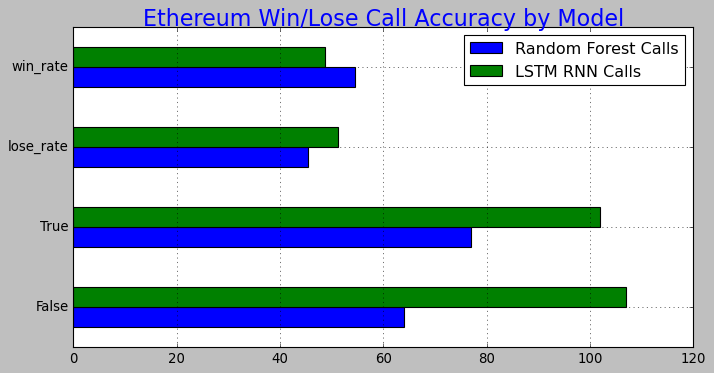

In [81]:
# Plot call accuracy by model
plt.style.use('classic')
combined_pivot = combined_pivot.plot(kind='barh', figsize=(10,5), fontsize=12, grid=True)
plt.title('Ethereum Win/Lose Call Accuracy by Model', fontsize=20, fontweight=15, color='blue', pad=1.0)
plt.savefig('images/eth-win-lose-compare.png')

---

## Dashboarding

In [82]:
from panel.interact import interact
import plotly.express as px
import panel as pn
pn.extension()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import matplotlib.image as img 
import holoviews as hv
from bokeh.plotting import figure

In [83]:
#Create dashboard panels and tabs
title1 = pn.pane.Markdown('#Indicators or Historical Price - which is the better predictor? ', style={'font-family': "serif", "font-color":"navy"})
title2 = pn.pane.Markdown('#Ethereum Historical Results', style={'font-family': "serif", "font-color":"navy"})
title3 = pn.pane.Markdown('#Ethereum Correlation and Features Importance', style={'font-family': "serif", "font-color":"navy"})
title4 = pn.pane.Markdown('#Ethereum Win/Lose Call Accuracy', style={'font-family': "serif", "font-color":"navy"})

banner = pn.pane.PNG('images/eth-banner.png', width=700, height=100)
lstm = pn.pane.PNG('images/eth-lstm.png', width=700, height=400)
heatmap = pn.pane.PNG('images/eth-rf-heatmap.png', width=800, height=600)
features = pn.pane.PNG('images/eth-features-import.png', width=700, height=400)
win_lose = pn.pane.PNG('images/eth-win-lose-compare.png', width=600)


overview_column = pn.Column(title1,
    '**PROJECT BACKGROUND** - '
    'Can cryptocurrency on-chain data paired with technical indicators '
    'fit to a Machine Learning model be a reliable predictor of '
    'the next daily close?'
    '',       
    'Is historical pricing the best indicator of a next day cryptocurrency price? '
    '',
    'The goal of this project is to determine if either of two models can be used '
    'to accurately predict a next-day price of three cryptocurrencies - ETH, BTC, DASH. '
    'A **Random Forest Regressor** model for technical indicators as features analysis '
    'and an **LSTM Recurrent Neural Network** model for the historical price analysis. ',
    
    '###**Ethereum Sentiment and Historical Features**',
    eth_df.head(), 
    banner,
    '###**Ethereum On-Chain Features**',
    eth_mining_df.head(),
    background='#E0DFE5', width=700, height=850, scroll=False)

lstm_column = pn.Column(title2,
    'How did predicted Ethereum prices perform against two-year historical prices?', 
    lstm, 
    background='#E0DFE5', width=800, height=1200, scroll=False)

random_forest_column = pn.Column(title3, 
    '**Which features ranked as most important and how did they correlate to the '
    'closing price, predicted price, and other features?**',
    features,
    heatmap,
    background='#E0DFE5', width=800, height=800, scroll=True)

results_column = pn.Column(title4,
    '**Which model had the best call accuracy for Ethereum?**', win_lose,
    background='#E0DFE5', width=700, height=500, scroll=False)               

backtest_column = pn.Column(
    lstm_prediction_profits(),
    '**LSTM Portfolio Evaluation**',
    portfolio_evaluation_df,
    '',
    '**LSTM Backtesting Metrics**',
    df,
    '',
    '**Random Forest Regressor Portfolio Evaluation**',
    rf_df,
    '',
    '**Random Forest Regressor Backtesting Metrics**',
    rf_portfolio_evaluation_df,
    rf_prediction_profits(),
    background='#E0DFE5', width=700, height=500, scroll=False) 

eth_dashboard = pn.Tabs(
    ("Overview", overview_column),
    ("LSTM RNN", lstm_column), 
    ("Random Forest Regressor", random_forest_column), 
    ("Backtesting", backtest_column),
    ("Results", results_column),
    dynamic=True)



### Serve the dashboard by executing the next cell.
To serve the dashboard to a browser, execute the next cell, open terminal, navigate to the directory of this file, and type the following: **panel serve --show filename.ipynb**

Tabs(dynamic=True)
    [0] Column(background='#E0DFE5', height=850, sizing_mode='fixed', width=700)
        [0] Markdown(str, style={'font-family': 'serif', ...})
        [1] Markdown(str)
        [2] Markdown(str)
        [3] Markdown(str)
        [4] Markdown(str)
        [5] DataFrame(DataFrame)
        [6] PNG(str, height=100, sizing_mode='fixed', width=700)
        [7] Markdown(str)
        [8] DataFrame(DataFrame)
    [1] Column(background='#E0DFE5', height=1200, sizing_mode='fixed', width=800)
        [0] Markdown(str, style={'font-family': 'serif', ...})
        [1] Markdown(str)
        [2] PNG(str, height=400, sizing_mode='fixed', width=700)
    [2] Column(background='#E0DFE5', height=800, scroll=True, sizing_mode='fixed', width=800)
        [0] Markdown(str, style={'font-family': 'serif', ...})
        [1] Markdown(str)
        [2] PNG(str, height=400, sizing_mode='fixed', width=700)
        [3] PNG(str, height=600, sizing_mode='fixed', width=800)
    [3] Column(background='#E0DFE5', height=500, sizing_mode='fixed', width=700)
        [0] HoloViews(Overlay)
        [1] Markdown(str)
        [2] DataFrame(DataFrame)
        [3] Markdown(str)
        [4] Markdown(str)
        [5] DataFrame(DataFrame)
        [6] Markdown(str)
        [7] Markdown(str)
        [8] DataFrame(DataFrame)
        [9] Markdown(str)
        [10] Markdown(str)
        [11] DataFrame(DataFrame)
        [12] HoloViews(Overlay)
    [4] Column(background='#E0DFE5', height=500, sizing_mode='fixed', width=700)
        [0] Markdown(str, style={'font-family': 'serif', ...})
        [1] Markdown(str)
        [2] PNG(str, width=600)
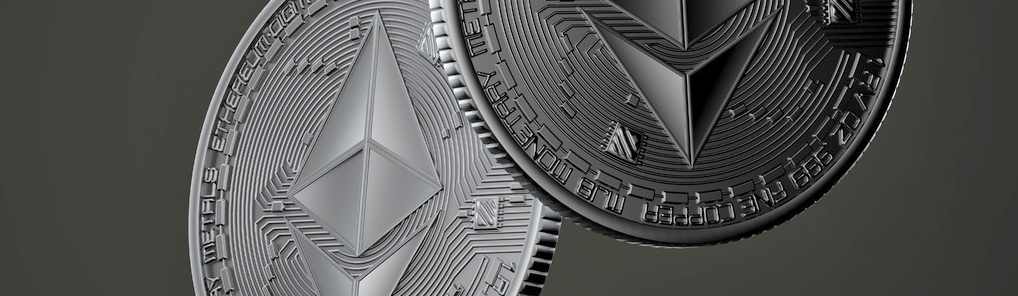

In [84]:
eth_dashboard.servable()